In [119]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from src.mplstyle import set as set_mplstyle
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.linear_model import LinearRegression

set_mplstyle("Fira Sans")

RESULTS_PATH = Path("./output/scaling_analysis/")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

DATA_DOC_PATH = Path("./data/dataset_docs/")
STATION_LIST = pd.read_csv(DATA_DOC_PATH / "pt_stations_ge30y_80pct_good.csv")

COLORS = ["#0C5DA5", "#FF2C00", "#FF9500", "#474747", "#9e9e9e"]
MARKERS = ["o", "s", "^", "*", "+"]



In [2]:
STATION_LIST

,StnID,Lat,Lon,Elev,State/Province,Name,UTC_Offset,POR_Date_Range_P,PCT_POR_Good_P,Num_Years_P,POR_Date_Range_T,Num_Years_T,PCT_POR_Good_T,overlap_years,PCT_Good_Overlap_1h,PCT_Good_Overlap_24h,Clim_Reg,KG
0,USC00410569,28.9798,-95.9749,15.8,TX,BAY CITY WATERWORKS,-6,19400601-20240417,57.1,84,19091001-20240331,116.0,70.2,85,87.1,89.5,S,14
1,USC00241737,47.8205,-112.1921,1172.0,MT,CHOTEAU,-7,19400101-20240401,93.8,84,18930101-20240504,132.0,83.6,85,96.2,98.1,NRP,7
2,USW00093914,31.7831,-95.6039,141.7,TX,PALESTINE 2 NE,-6,19400201-20240213,86.7,84,19300101-20240324,95.0,92.2,85,91.7,89.2,S,14
3,USC00414670,30.4452,-99.8044,532.5,TX,JUNCTION 4SSW,-6,19400301-20240401,90.4,84,18970127-20240503,128.0,75.0,85,84.5,88.7,S,6
4,USC00319476,35.6939,-77.9461,33.5,NC,WILSON 3 SW,-5,19400801-20240415,82.6,84,19161001-20240502,109.0,81.6,85,97.7,98.8,SE,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,USC00170100,44.3738,-68.2591,143.3,ME,ACADIA NATIONAL PARK,-5,19820907-20120704,86.8,30,19820901-20140531,33.0,94.8,31,94.8,94.4,NE,26
709,USC00478316,42.9676,-88.5495,283.2,WI,SULLIVAN 3 SE - WFO MKX,-6,19940901-20240402,85.6,30,19950101-20240504,30.0,96.8,30,98.2,97.7,UM,25
710,USC00084095,25.5011,-80.5500,2.7,FL,HOMESTEAD GEN AVIATION AP,-5,19950701-20240402,84.0,29,19900601-20240504,35.0,88.2,30,95.3,94.5,SE,3
711,USC00033544,36.0700,-93.7522,543.5,AR,HUNTSVILLE 1 SSW,-6,19830501-20120925,90.1,29,19830501-20120924,30.0,97.2,30,97.0,97.7,S,14


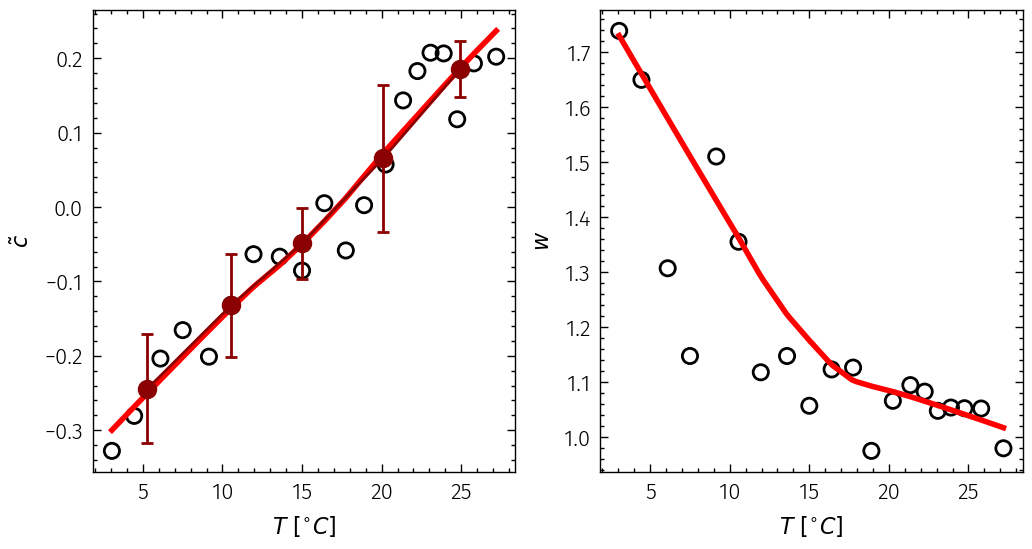

In [93]:
def lowess_and_interp(x, y, x_interp, frac=0.5):
    x_interp = np.asarray(x_interp)

    loess_result = lowess(y, x, frac=frac, return_sorted=True)
    x_loess, y_loess = loess_result[:, 0], loess_result[:, 1]

    loess_interp = interp1d(x_loess, y_loess, kind="linear", fill_value="extrapolate")
    return loess_interp(x_interp)

stn_id = "USC00114198"
d = "1h"
var = "TMEAN"
cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)


cw_scaling = normalize_results(cw_scaling, normalization, var=var, center_temp=False)
if var == "TMEAN":
    cw_scaling['c'] = np.log10(cw_scaling['c'])

T_interp = np.linspace(cw_scaling[f"{var}_med"].min(), cw_scaling[f"{var}_med"].max(), 100)

c_interpolated = lowess_and_interp(cw_scaling[f"{var}_med"].values, cw_scaling["c"].values, T_interp, frac=0.7)
w_interpolated = lowess_and_interp(cw_scaling[f"{var}_med"].values, cw_scaling["w"].values, T_interp, frac=0.7)

c_bin = bin_and_analyze(cw_scaling, n_bins=5, x_col='TMEAN_med', y_col='c')

fig, axs = plt.subplots(1, 2, figsize=(6,3))

axs[0].scatter(cw_scaling[f"{var}_med"], cw_scaling["c"], s=30, ec='k', fc='none')
axs[0].plot(T_interp, c_interpolated, "-r", lw=2)

# axs[0].plot(c_bin["x_mean"], c_bin["c_mean"], '-o', lw=2, c="darkred")
# axs[0].fill_between(c_bin["x_mean"], 
#                     c_bin["c_mean"] - c_bin["c_std"], 
#                     c_bin["c_mean"] + c_bin["c_std"], 
#                     alpha=0.3, color="darkred")
axs[0].errorbar(c_bin["x_mean"], c_bin["c_mean"], yerr=c_bin["c_std"], fmt='-o', lw=1, c="darkred", capsize=2)

axs[1].plot(T_interp, w_interpolated, "-r", lw=2)
axs[1].scatter(cw_scaling[f"{var}_med"], cw_scaling["w"], s=30, ec='k', fc='none')

#plot_cc_reference_line(axs[0])
axs[0].set(xlabel="$T~[^{\circ} C]$", ylabel="$\\tilde{c}$")
axs[1].set(xlabel="$T~[^{\circ} C]$", ylabel="$w$")
plt.show()

In [ ]:
kg_descriptions = {
            1: 'Af',
            2: 'Am',
            3: 'Aw',
            4: 'BWh',
            5: 'BWk',
            6: 'BSh',
            7: 'BSk',
            8: 'Csa',
            9: 'Csb',
            10: 'Csc',
            11: 'Cwa',
            12: 'Cwb',
            13: 'Cwc',
            14: 'Cfa',
            15: 'Cfb',
            16: 'Cfc',
            17: 'Dsa',
            18: 'Dsb',
            19: 'Dsc',
            20: 'Dsd',
            21: 'Dwa',
            22: 'Dwb',
            23: 'Dwc',
            24: 'Dwd',
            25: 'Dfa',
            26: 'Dfb',
            27: 'Dfc',
            28: 'Dfd',
            29: 'ET',
            30: 'EF'
        }

def load_pt_scaling_results(stn_id, duration, var):
    """ 
    Load the scaling analysis results with TMEAN as exogenous variable for a single duration
    """
    cw_scaling = pd.read_csv(RESULTS_PATH / duration / var / f"cw_scaling_{stn_id}.csv")
    with open(RESULTS_PATH / duration / var / f"cw_normalization_{stn_id}.json", 'r') as f:
        normalization = json.load(f)
    return cw_scaling, normalization

def plot_cc_reference_line(ax, T=None, super_cc=False):
    if T is None:
        T = np.linspace(-5, 35, 20)
    for c0 in [1e-2, 1e-1, 1, 1e1, 1e2]:
        # Standard CC scaling
        ax.plot(T, (c0 * (0.068 + 1) ** T), "--k", linewidth=0.2)
        if super_cc:
            # Super-CC scaling
            ax.plot(
                T, (c0 * (2 * 0.068 + 1) ** T), "--", alpha=0.8, linewidth=0.2, c="r"
            )



def bin_and_analyze(df, n_bins=10, x_col='TMEAN_med', y_col='c'):
    """
    Bin pooled data into equal-sized bins and compute bin statistics
    """
    df = df.copy()
    df['bin'] = pd.cut(df[x_col], bins=n_bins, labels=False)
    
    bin_stats = df.groupby('bin').agg({
        x_col: ['mean', 'count'],
        y_col: ['mean', 'std']
    }).round(4)
    

    bin_stats.columns = ['x_mean', 'count', y_col+'_mean', y_col+'_std']
    bin_stats = bin_stats.reset_index()
    bin_stats = bin_stats.dropna()
    return bin_stats

def normalize_results(cw_scaling_, normalization, var, center_temp=True):
    cw_scaling = cw_scaling_.copy()
    cw_scaling["c"] = cw_scaling["c"] / normalization["c0"]
    cw_scaling["w"] = cw_scaling["w"] / normalization["w0"]
    if var == "TMEAN" and center_temp:
        cw_scaling[f"{var}_med"] = cw_scaling[f"{var}_med"] - normalization["Tmean"]

    return cw_scaling

def plot_scaling(d, var, xlabel, center_temp=False):
    # Configuration
    ylabels = ["$log~\\tilde{c}$" if var == "TMEAN" else "$\\tilde{c}$", "$w$"]
    groups = [[14, 25, 7], [26, 5, 9]]
    params = ["c", "w"]
    
    fig, axs = plt.subplots(2, 2, figsize=(5, 4), tight_layout=True)
    
    # Process data and collect limits
    xlim, ylim = {param: [] for param in params}, {param: [] for param in params}
    
    for i, group in enumerate(groups):
        plot_group_data(axs, group, i, d, var, center_temp)
        collect_axis_limits(axs, xlim, ylim, i)
    
    # Set axis properties
    setup_axes(axs, xlim, ylim, ylabels, xlabel, var)
    plt.suptitle(f"{var} - {d}", fontsize=12)
    plt.show()


def plot_group_data(axs, group, col_idx, d, var, center_temp):
    """Plot data for a single group of regions."""
    for j, region in enumerate(group):
        stations = STATION_LIST[STATION_LIST["KG"] == region]["StnID"].values
        pooled_cw = process_stations(stations, d, var, center_temp)
        
        plot_parameters(axs, pooled_cw, col_idx, j, region, var)


def process_stations(stations, d, var, center_temp):
    """Process all stations and return pooled results."""
    pool = []
    for stn_id in stations:
        cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
        cw_scaling = normalize_results(cw_scaling, normalization, var=var, center_temp=center_temp)
        
        if var == "TMEAN":
            cw_scaling['c'] = np.log10(cw_scaling['c'])
        
        pool.append(cw_scaling)
    
    return pd.concat(pool)


def plot_parameters(axs, pooled_cw, col_idx, region_idx, region, var):
    """Plot both parameters (c and w) for the given data."""
    for param_idx, param in enumerate(["c", "w"]):
        res = bin_and_analyze(pooled_cw, n_bins=50, x_col=var+'_med', y_col=param)
        
        ax = axs[param_idx, col_idx]
        color = COLORS[region_idx]
        
        # Mean scaling
        ax.plot(res["x_mean"], res[f"{param}_mean"], '-', 
                lw=2, c=color, label=kg_descriptions[region])
        
        # Error band (std)
        ax.fill_between(res["x_mean"],
                       res[f"{param}_mean"] - res[f"{param}_std"],
                       res[f"{param}_mean"] + res[f"{param}_std"],
                       alpha=0.3, color=color)


def collect_axis_limits(axs, xlim, ylim, col_idx):
    """Collect axis limits for later synchronization."""
    xlim["c"].append(axs[0, col_idx].get_xlim())
    xlim["w"].append(axs[1, col_idx].get_xlim())
    ylim["c"].append(axs[0, col_idx].get_ylim())
    ylim["w"].append(axs[1, col_idx].get_ylim())


def setup_axes(axs, xlim, ylim, ylabels, xlabel, var):
    """Configure axis properties, labels, and limits."""
    # Convert to arrays for easier manipulation
    for param in ["c", "w"]:
        xlim[param] = np.asarray(xlim[param])
        ylim[param] = np.asarray(ylim[param])
    
    for i in range(2):  # rows
        for j in range(2):  # columns
            ax = axs[i, j]
            
            # Top row (c parameter)
            if i == 0:
                add_cc_scaling_lines(ax, xlim, ylim, var)
                ax.set_xlim(xlim["c"][:, 0].min(), xlim["c"][:, 1].max())
                ax.set_ylim(ylim["c"][:, 0].min(), ylim["c"][:, 1].max())
            
            # Bottom row (w parameter)
            if i == 1:
                ax.legend()
                ax.set_xlabel(xlabel)
                ax.set_xlim(xlim["w"][:, 0].min(), xlim["w"][:, 1].max())
                ax.set_ylim(ylim["w"][:, 0].min(), ylim["w"][:, 1].max())
            
            # Left column
            if j == 0:
                ax.set_ylabel(ylabels[i])


def add_cc_scaling_lines(ax, xlim, ylim, var):
    """Add CC-scaling reference lines for temperature data."""
    if var == "TMEAN":
        for c0 in np.linspace(ylim["c"][:, 0].min(), ylim["c"][:, 1].max(), 3):
            T = np.linspace(xlim["c"][:, 0].min(), xlim["c"][:, 1].max(), 10)
            y_line = c0 + np.log10(0.068 + 1) * (T - np.mean(T))
            ax.plot(T, y_line, "--k", linewidth=0.2)

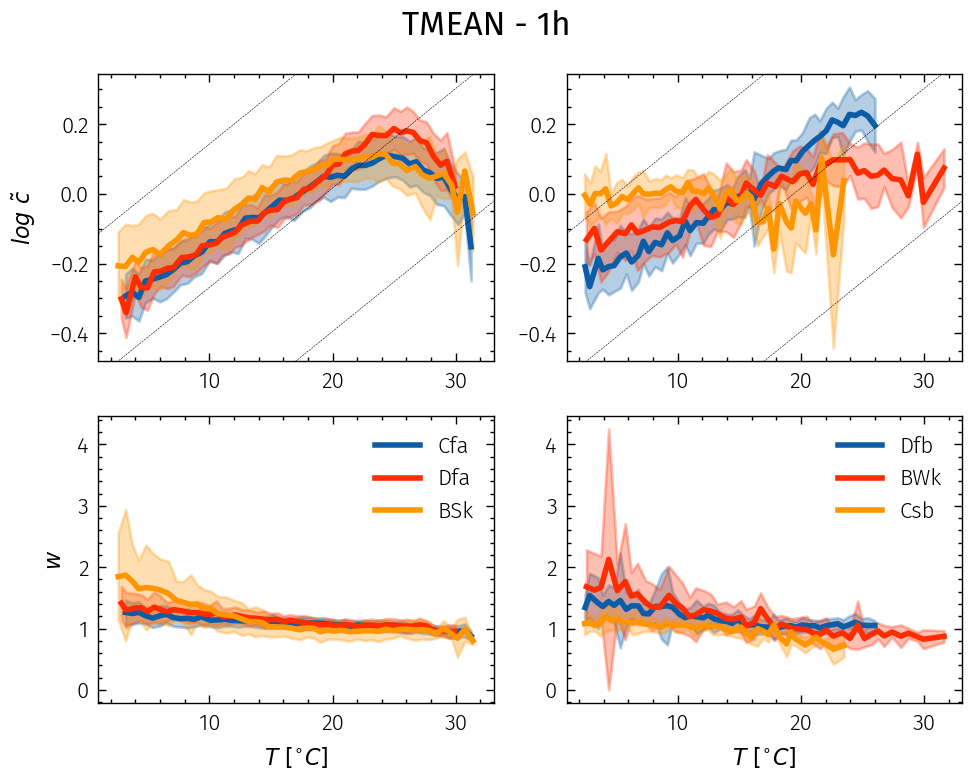

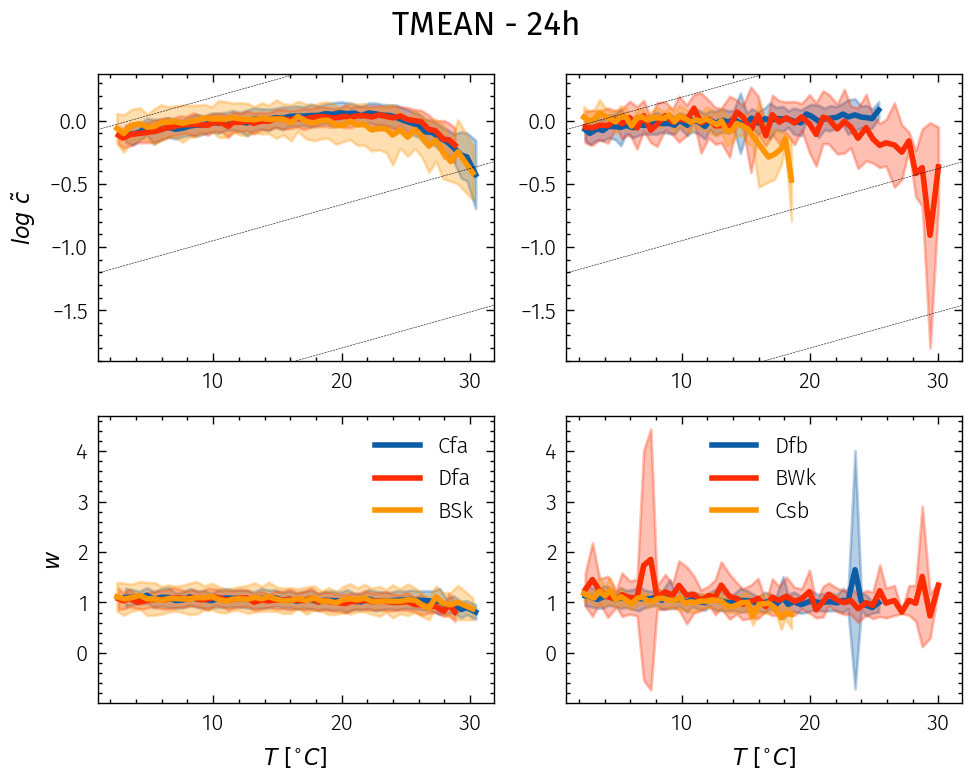

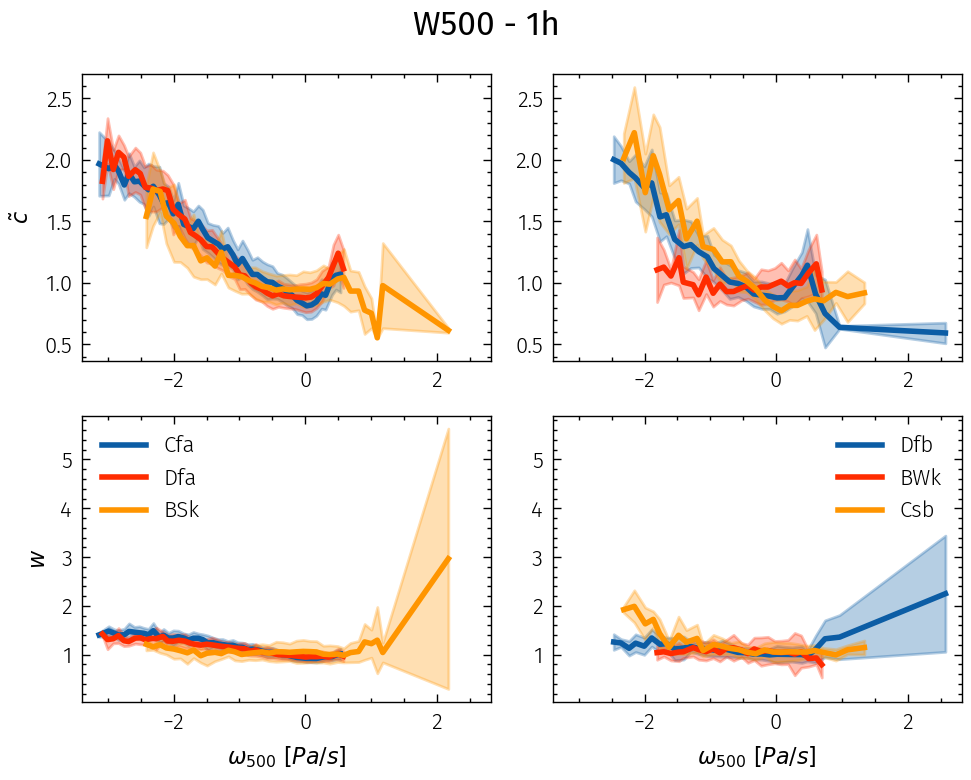

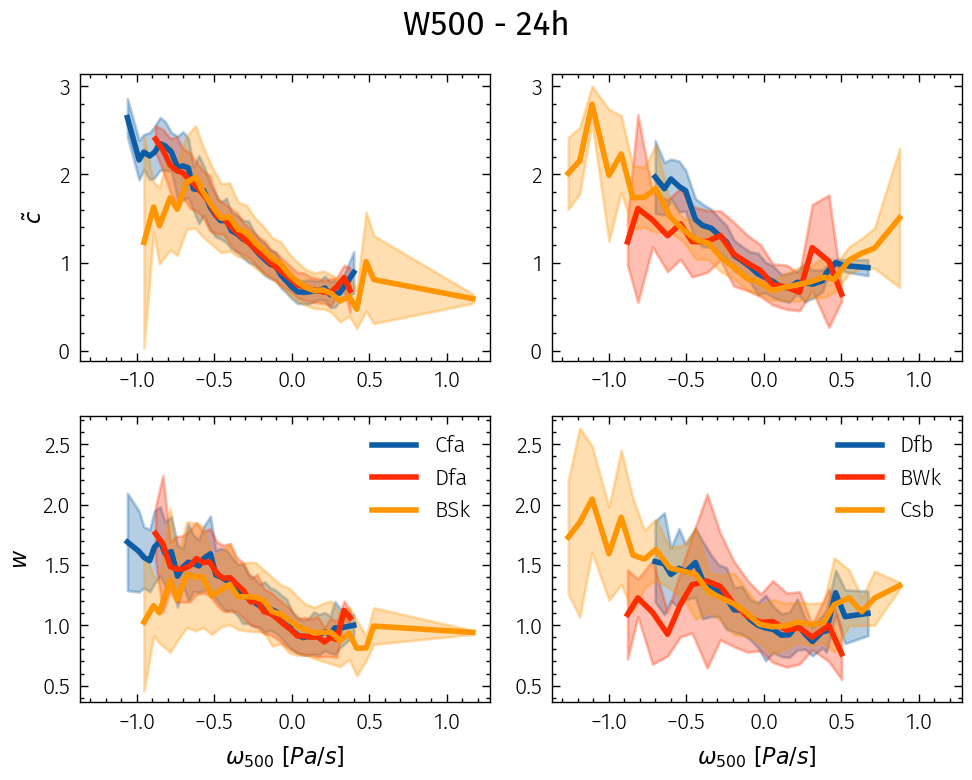

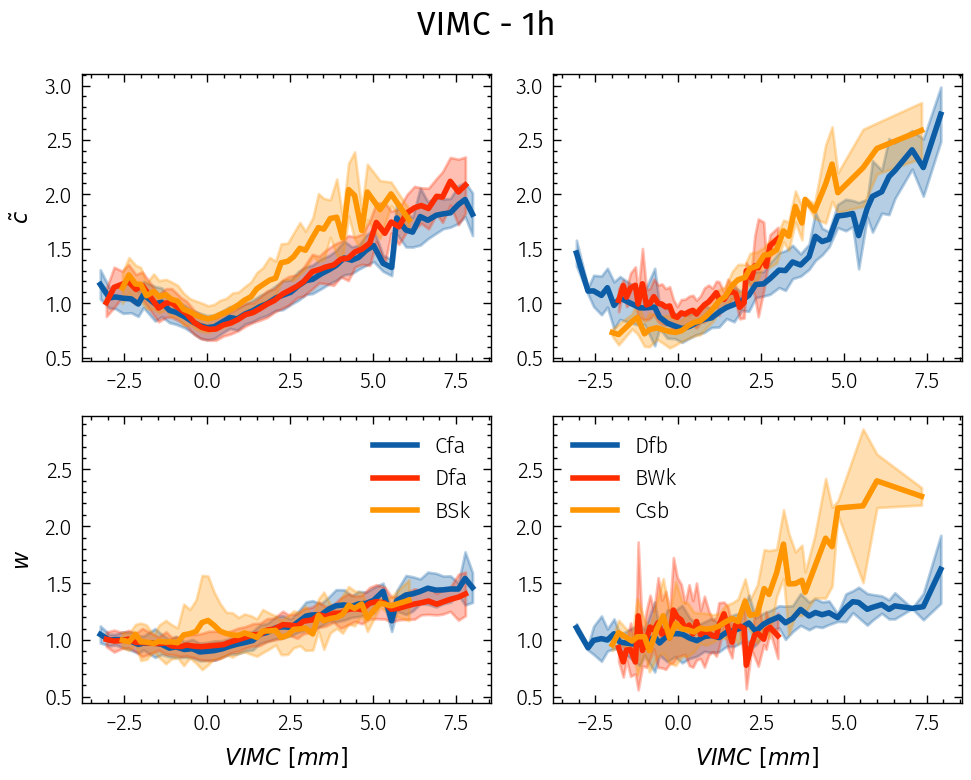

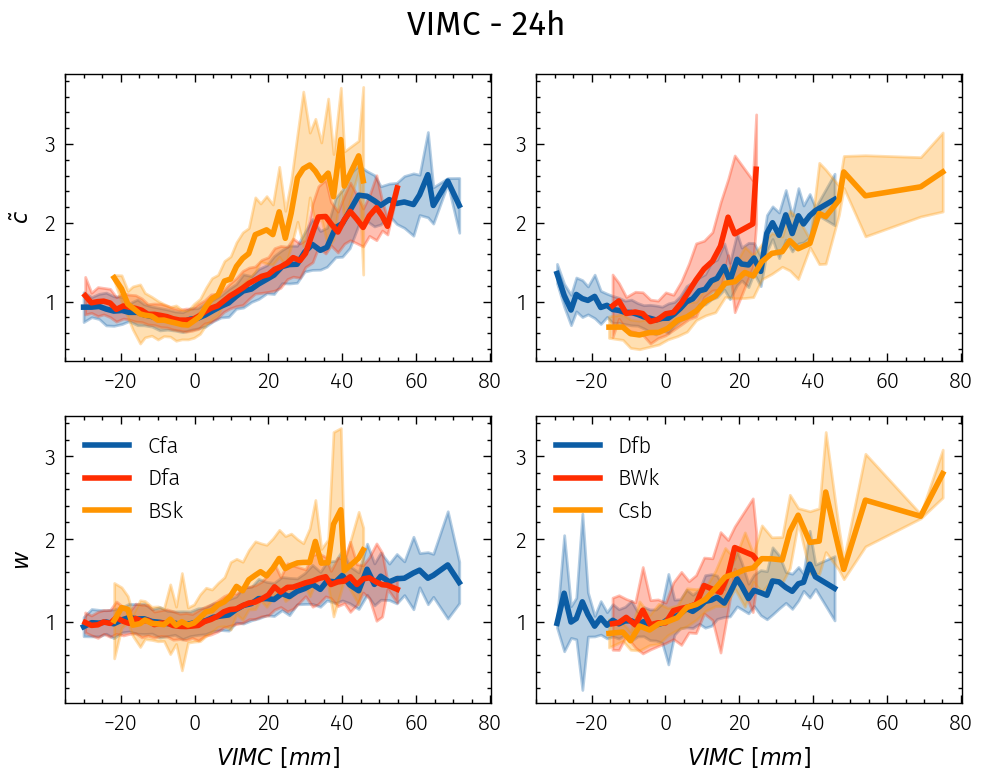

In [15]:
d = "1h"
var = "TMEAN"
xlabel = "$T~[^{\circ} C]$"

for var, xlabel in zip(["TMEAN","W500","VIMC"], ["$T~[^{\circ} C]$", "$\omega_{500}~[Pa/s]$", "$VIMC~[mm]$"]):
    for d in ["1h", "24h"]:
        plot_scaling(d, var, xlabel, center_temp=False)

# Supplementary info

In [87]:
def plot_single_station_scaling(stn_id, savedir, title=None):
    vars = ["TMEAN", "W500", "VIMC"]
    durations = ["1h","24h"]
    xlabels = [r"$T~[^{\circ} C]$", r"$\omega_{500}~[Pa/s]$", r"$VIMC~[mm]$"]

    fig = plt.figure(figsize=(8, 7), constrained_layout=True)
    subfigs = fig.subfigures(3, 1, height_ratios=[1, 1, 1])

    for i, var in enumerate(vars):
        ylabels = ["$log~c [mm]$" if var == "TMEAN" else "$c [mm]$", "$w$"]
        subfigs_duration = subfigs[i].subfigures(1, 2, width_ratios=[1, 1])

        for j, d in enumerate(durations):
            axs = subfigs_duration[j].subplots(1, 2)
            subfigs_duration[j].suptitle(f"{var} - {d}", fontsize=10)

            cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
            if var == "TMEAN":
                cw_scaling['c'] = np.log10(cw_scaling['c'])
                
            axs[0].scatter(cw_scaling[f"{var}_med"], cw_scaling["c"], s=30, ec='k', fc='none')
            axs[1].scatter(cw_scaling[f"{var}_med"], cw_scaling["w"], s=30, ec='k', fc='none')
            
            if var == "TMEAN":
                xlim = axs[0].get_xlim()
                ylim = axs[0].get_ylim()
                for c0 in np.linspace(cw_scaling['c'].min(), cw_scaling['c'].max(), 3):
                    T = np.linspace(cw_scaling['TMEAN_med'].min()-5, cw_scaling['TMEAN_med'].max()+5, 10)
                    y_line = c0 + np.log10(0.068 + 1) * (T - np.mean(T))
                    axs[0].plot(T, y_line, "--k", linewidth=0.2)
                axs[0].set_xlim(xlim)
                axs[0].set_ylim(ylim)

            for param_idx, param in enumerate(["c", "w"]):
                axs[param_idx].set_xlabel(xlabels[i])
                axs[param_idx].set_ylabel(ylabels[param_idx])

    plt.suptitle(title, fontsize=10, color="r")
    plt.savefig(savedir / (stn_id + ".pdf"), dpi=300, format="pdf")
    plt.close()



In [153]:
kg_full = {
            1: 'Af - Tropical, rainforest',
            2: 'Am - Tropical, monsoon',
            3: 'Aw - Tropical, savannah',
            4: 'BWh - Arid, desert, hot',
            5: 'BWk - Arid, desert, cold',
            6: 'BSh - Arid, steppe, hot',
            7: 'BSk - Arid, steppe, cold',
            8: 'Csa - Temperate, dry summer, hot summer',
            9: 'Csb - Temperate, dry summer, warm summer',
            10: 'Csc - Temperate, dry summer, cold summer',
            11: 'Cwa - Temperate, dry winter, hot summer',
            12: 'Cwb - Temperate, dry winter, warm summer',
            13: 'Cwc - Temperate, dry winter, cold summer',
            14: 'Cfa - Temperate, no dry season, hot summer',
            15: 'Cfb - Temperate, no dry season, warm summer',
            16: 'Cfc - Temperate, no dry season, cold summer',
            17: 'Dsa - Cold, dry summer, hot summer',
            18: 'Dsb - Cold, dry summer, warm summer',
            19: 'Dsc - Cold, dry summer, cold summer',
            20: 'Dsd - Cold, dry summer, very cold winter',
            21: 'Dwa - Cold, dry winter, hot summer',
            22: 'Dwb - Cold, dry winter, warm summer',
            23: 'Dwc - Cold, dry winter, cold summer',
            24: 'Dwd - Cold, dry winter, very cold winter',
            25: 'Dfa - Cold, no dry season, hot summer',
            26: 'Dfb - Cold, no dry season, warm summer',
            27: 'Dfc - Cold, no dry season, cold summer',
            28: 'Dfd - Cold, no dry season, very cold winter',
            29: 'ET - Polar, tundra',
            30: 'EF - Polar, frost'
        }

np.random.seed(0)

groups = [[14, 25, 7], [26, 5, 9]]
for i, group in enumerate(groups):
    for j, region in enumerate(group):
        stations = STATION_LIST[STATION_LIST["KG"] == region]["StnID"].values
        sample = np.random.choice(stations, size=min(len(stations), 30), replace=False)

        for stn_id in sample:
            savedir = Path("output/supplementary_info/" + kg_descriptions[region])
            savedir.mkdir(parents=True, exist_ok=True)
            plot_single_station_scaling(stn_id, savedir, title=f"{', '.join(STATION_LIST.loc[STATION_LIST['StnID'] == stn_id, ['Name','State/Province']].values[0])} ({stn_id}) - {kg_full[region]}")

# Distribution of slopes

In [ ]:
def compute_local_slopes(df, x_col, y_col, intervals, 
                        adjacent_points=1, min_points=5):
    """
    Compute local slopes for different intervals of x using linear regression.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    x_col : str
        Name of the predictor column (default: 'x')
    y_col : str
        Name of the dependent variable column (default: 'y')
    intervals : list of tuples
        List of (start, end) tuples defining the intervals
        Default: [(5,10), (10,15), (15,20), (20,25), (25,30)]
    adjacent_points : int
        Number of points to include from adjacent intervals 
        Minimum number of points required for regression

    Returns:
    --------
    pandas.DataFrame
        DataFrame with interval information and computed slopes
    """
    
    results = []
    
    # Sort dataframe by x values
    df_sorted = df.sort_values(x_col).reset_index(drop=True)
    for i, (start, end) in enumerate(intervals):
        mask_current = (df_sorted[x_col] >= start) & (df_sorted[x_col] <= end)
        current_points = df_sorted[mask_current]
        additional_points = pd.DataFrame()
        
        if i > 0:
            prev_start, prev_end = intervals[i-1]
            mask_prev = (df_sorted[x_col] >= prev_start) & (df_sorted[x_col] <= prev_end)
            prev_points = df_sorted[mask_prev]
            if len(prev_points) > 0:
                additional_points = pd.concat([additional_points, 
                                             prev_points.tail(adjacent_points)])
        
        if i < len(intervals) - 1:
            next_start, next_end = intervals[i+1]
            mask_next = (df_sorted[x_col] >= next_start) & (df_sorted[x_col] < next_end)
            next_points = df_sorted[mask_next]
            if len(next_points) > 0:
                additional_points = pd.concat([additional_points, 
                                             next_points.head(adjacent_points)])
        
        all_points = pd.concat([current_points, additional_points]).drop_duplicates()
        all_points = all_points.sort_values(x_col)
        
        n_points = len(all_points)
        n_current = len(current_points)

        result = {
            'interval': f'{start}-{end}',
            'n_points_in_interval': n_current,
            'n_total_points_used': n_points,
            'slope': np.nan,
            'r_squared': np.nan,
            'SR': np.nan,
            'valid_regression': False
        }
        
        if n_points >= min_points and n_current > 0:
            X = all_points[x_col].values.reshape(-1, 1)
            y = all_points[y_col].values
            
            reg = LinearRegression()
            reg.fit(X, y)
            
            # R-squared
            y_pred = reg.predict(X)
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            result.update({
                'slope': reg.coef_[0],
                'r_squared': r_squared,
                'SR': (np.power(10, reg.coef_[0]) - 1)*100,
                'valid_regression': True,
            })
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df


def create_slope_distribution_plots(ax, combined_results, y_col, intervals):
    """
    Create violin plot and additional visualizations for slope distributions.
    """
    interval_order = [f"{start}-{end}" for start, end in intervals]
    available_intervals = combined_results['interval'].unique()
    plot_intervals = [inv for inv in interval_order if inv in available_intervals]
    
    if len(plot_intervals) > 0:
        violin_data = []
        labels = []
        for i, interval in enumerate(plot_intervals):
            sr = combined_results[combined_results['interval'] == interval][y_col].values
            if len(sr) > 0:
                violin_data.append(sr)
                labels.append(f"{interval}")
                x_coords = np.random.normal(i, 0.04, len(sr)) # Add jitter to x-coordinates for better visibility
                ax.scatter(x_coords, sr, alpha=0.6, s=20, color='grey', zorder=10)
        
        if violin_data:
            parts = ax.violinplot(violin_data, positions=range(len(violin_data)), 
                                 widths=0.7, showmedians=True)
            
            for pc in parts['bodies']:
                pc.set_facecolor('lightgrey')
                pc.set_alpha(0.7)
            
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels)
            ax.set_ylabel('SR [%]' if y_col=="SR" else "Slope")
            ax.tick_params(axis='x', which='minor', bottom=False)
            if y_col=="SR":
                ax.axhline(y=6.8, color='r', linestyle='--', alpha=0.5)
    

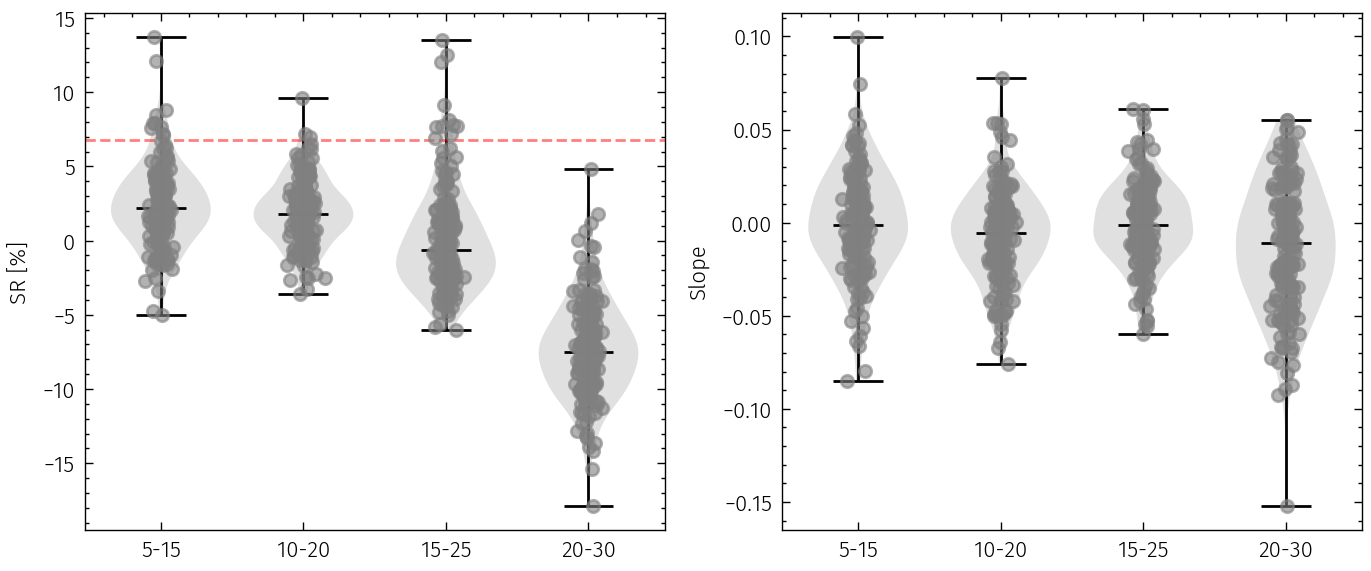

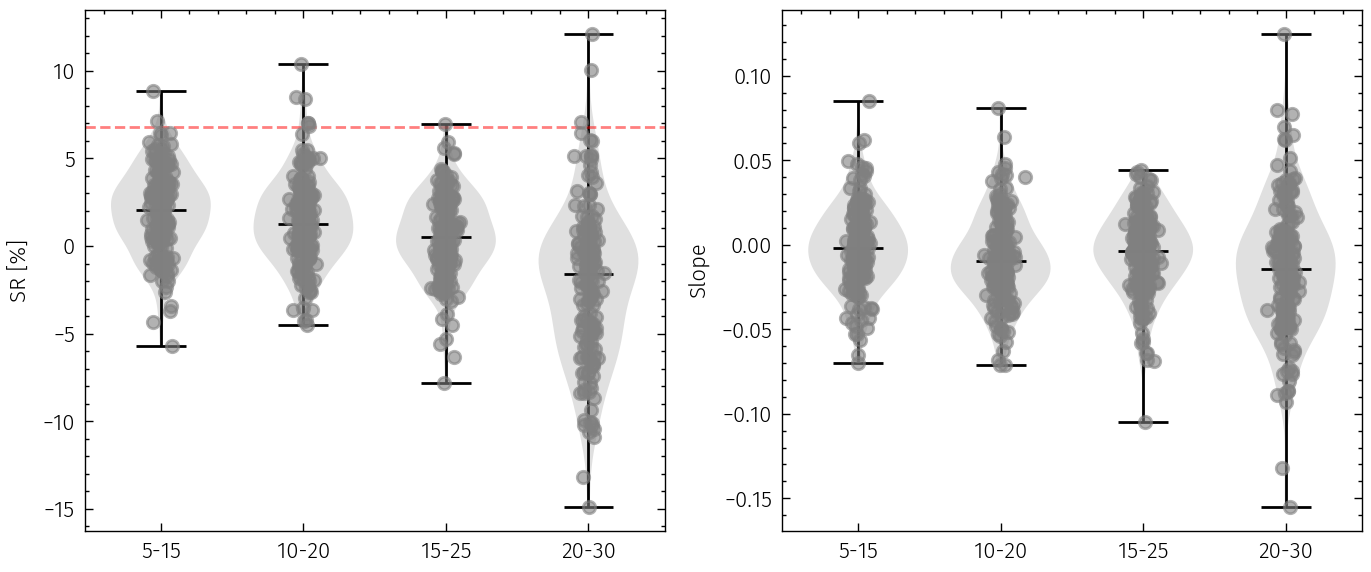

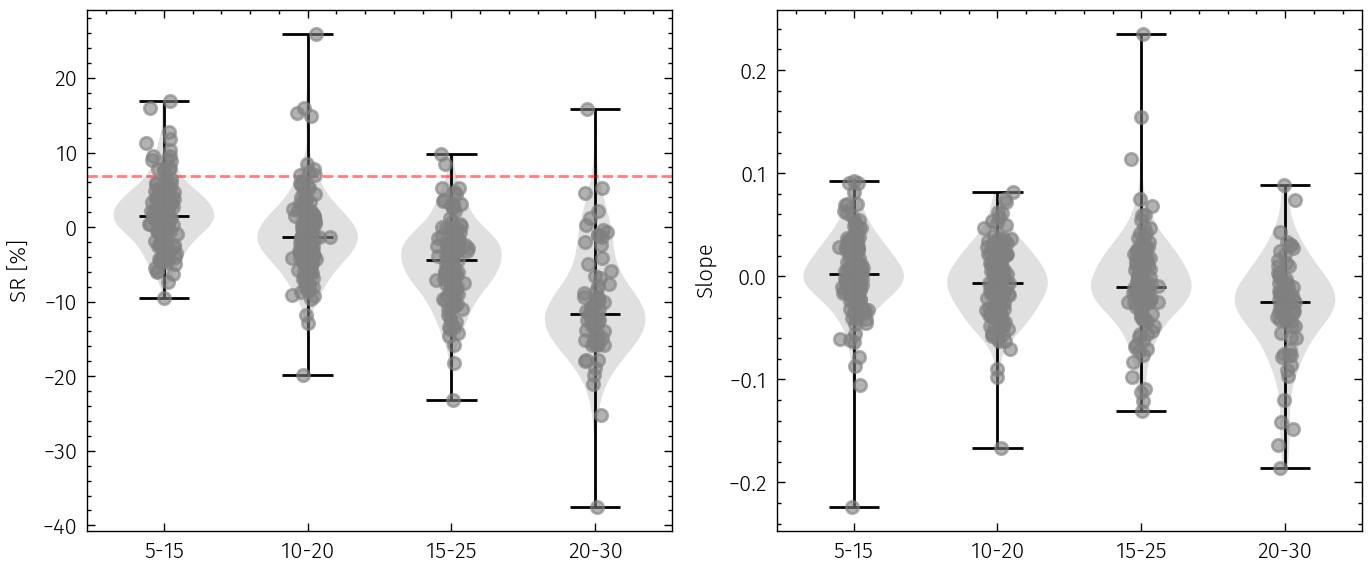

In [152]:
d = "24h"
var = "TMEAN"
y_cols = ['SR', "slope"]

intervals = [(5, 15), (10, 20), (15, 25), (20, 30)]
#intervals = [(5, 10), (10, 15), (15, 20), (20, 25), (25, 30)]

for i, group in enumerate(groups):
    for j, region in enumerate(group):
        fig, axs = plt.subplots(1, 2, figsize=(7,3))
        stations = STATION_LIST[STATION_LIST["KG"] == region]["StnID"].values
        all_results = {"c": [], "w": []}
        for stn_id in stations:
            cw_scaling, normalization = load_pt_scaling_results(stn_id, d, var)
            if var == "TMEAN":
                cw_scaling['c'] = np.log10(cw_scaling['c'])
            
            for k, param in enumerate(["c", "w"]):
                res = compute_local_slopes(cw_scaling, x_col=var+"_med", y_col=param, intervals=intervals, 
                        adjacent_points=1, min_points=5)
                valid_results = res[res['valid_regression'] == True].copy()
                if len(valid_results) > 0:
                    valid_results['station_id'] = stn_id
                    all_results[param].append(valid_results)

        for k, param in enumerate(["c", "w"]):
            combined_results = pd.concat(all_results[param], ignore_index=True)
            create_slope_distribution_plots(axs[k], combined_results, y_cols[k], intervals)
        plt.tight_layout()
        plt.show()
    break

